# Assignment 02 - Part 3: Search & Evaluation

## Î™©Ìëú
- 4Í∞ÄÏßÄ Í≤ÄÏÉâ Î∞©Î≤ï Íµ¨ÌòÑ
  1. Dense (Vector) only
  2. BM25 (Keyword) only
  3. Hybrid (RRF or Weighted Fusion)
  4. Hybrid + Re-rank (Cross-Encoder)
- ÌèâÍ∞Ä Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞ (Recall@5/10, MRR@10, NDCG@10, Latency)
- Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑù

In [9]:
import sys
print(sys.executable)


/home/dhc99/anaconda3/envs/torch_env/bin/python


In [1]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import os
import json
import yaml
import pandas as pd
import numpy as np
import pickle
import time
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Any, Tuple
from collections import defaultdict

# Pinecone
from pinecone import Pinecone

# Embeddings & Reranking
from sentence_transformers import SentenceTransformer, CrossEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
from sklearn.metrics import ndcg_score

# ÌôòÍ≤Ω Î≥ÄÏàò
from dotenv import load_dotenv
load_dotenv()

# Í≤ΩÎ°ú ÏÑ§Ï†ï
PROJECT_ROOT = Path('/home/dhc99/ajou-llmops-2025-2nd-semester/assignment02')
DATA_DIR = PROJECT_ROOT / 'datasets'
CONFIG_DIR = PROJECT_ROOT / 'configs'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
RESULTS_DIR = PROJECT_ROOT / 'results'
PLOTS_DIR = RESULTS_DIR / 'plots'
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print(f"‚úÖ Project initialized")

/home/dhc99/anaconda3/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


‚úÖ Project initialized


In [2]:
# ÏÑ§Ï†ï Î°úÎìú
with open(CONFIG_DIR / 'models.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("üìã Configuration loaded")
print(f"  - Hybrid method: {config['hybrid']['method']}")
print(f"  - RRF k: {config['hybrid']['rrf_k']}")
print(f"  - Reranker: {config['reranker']['model_name']}")
print(f"  - Top-N: {config['reranker']['top_n']}, Top-K: {config['reranker']['top_k']}")
print(f"  ‚ö° Performance: top_n={config['reranker']['top_n']} (Îπ†Î•∏ ÌèâÍ∞ÄÎ•º ÏúÑÌï¥ ÏµúÏ†ÅÌôî)")

üìã Configuration loaded
  - Hybrid method: rrf
  - RRF k: 60
  - Reranker: jinaai/jina-reranker-v2-base-multilingual
  - Top-N: 20, Top-K: 10
  ‚ö° Performance: top_n=20 (Îπ†Î•∏ ÌèâÍ∞ÄÎ•º ÏúÑÌï¥ ÏµúÏ†ÅÌôî)


In [3]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
print("üì• Loading data...")

# Ï≤≠ÌÅ¨ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞
chunks_df = pd.read_parquet(ARTIFACTS_DIR / 'chunks_metadata.parquet')
print(f"  ‚úÖ Chunks: {len(chunks_df):,}")

# ÏûÑÎ≤†Îî©
embeddings = np.load(ARTIFACTS_DIR / 'embeddings.npy')
print(f"  ‚úÖ Embeddings: {embeddings.shape}")

# BM25 Ïù∏Îç±Ïä§
with open(ARTIFACTS_DIR / 'bm25_index.pkl', 'rb') as f:
    bm25_data = pickle.load(f)
    bm25 = bm25_data['bm25']
    tokenized_corpus = bm25_data['tokenized_corpus']
    chunk_ids = bm25_data['chunk_ids']
print(f"  ‚úÖ BM25 index loaded")

# ÌèâÍ∞Ä ÏøºÎ¶¨
eval_queries_df = pd.read_csv(DATA_DIR / 'eval_queries.csv')
print(f"  ‚úÖ Eval queries: {len(eval_queries_df)}")

üì• Loading data...
  ‚úÖ Chunks: 641
  ‚úÖ Embeddings: (641, 1024)
  ‚úÖ BM25 index loaded
  ‚úÖ Eval queries: 50


In [7]:
!pip install einops

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)

Using cached einops-0.8.1-py3-none-any.whl (64 kB)


In [4]:
# Î™®Îç∏ Î°úÎìú
print("\nüì• Loading models...")

# Embedding model (02_index_pinecone.ipynbÏôÄ ÎèôÏùºÌïú Î™®Îç∏ ÏÇ¨Ïö© - 1024 dim ÌïÑÏàò)
print("   Loading intfloat/multilingual-e5-large (1024 dimensions)...")
embedding_model = SentenceTransformer(
    "intfloat/multilingual-e5-large",
    device='cuda' if config['embedding']['device'] == 'cuda' else 'cpu'
)
# Config ÏóÖÎç∞Ïù¥Ìä∏
config['embedding']['model_name'] = "intfloat/multilingual-e5-large"
config['pinecone']['dimension'] = 1024
config['embedding']['normalize'] = True

print(f"  ‚úÖ Embedding model: {config['embedding']['model_name']}")
print(f"  üìä Embedding dimension: {config['pinecone']['dimension']}")

# Reranker model
reranker_model = CrossEncoder(
    config['reranker']['model_name'],
    max_length=512,
    device='cuda' if config['embedding']['device'] == 'cuda' else 'cpu',
    trust_remote_code=True  # Jina Î™®Îç∏ÏùÄ Ïª§Ïä§ÌÖÄ ÏΩîÎìú ÌïÑÏöî
)
print(f"  ‚úÖ Reranker model: {config['reranker']['model_name']}")

# Pinecone
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))
index = pc.Index(config['pinecone']['index_name'])
print(f"  ‚úÖ Pinecone index: {config['pinecone']['index_name']}")


üì• Loading models...
   Loading intfloat/multilingual-e5-large (1024 dimensions)...
  ‚úÖ Embedding model: intfloat/multilingual-e5-large
  üìä Embedding dimension: 1024


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention impl

  ‚úÖ Reranker model: jinaai/jina-reranker-v2-base-multilingual
  ‚úÖ Pinecone index: rag-assignment-korquad


## 1. Í≤ÄÏÉâ Ìï®Ïàò Íµ¨ÌòÑ

In [5]:
def tokenize(text: str) -> List[str]:
    """Í∞ÑÎã®Ìïú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä"""
    return text.lower().split()


def dense_search(query: str, top_k: int = 10) -> List[Dict]:
    """
    Dense (Vector) Í≤ÄÏÉâ
    
    Args:
        query: Í≤ÄÏÉâ ÏøºÎ¶¨
        top_k: Î∞òÌôòÌï† Í≤∞Í≥º Ïàò
    
    Returns:
        Í≤ÄÏÉâ Í≤∞Í≥º Î¶¨Ïä§Ìä∏ [{chunk_id, score, text, ...}, ...]
    """
    # ÏøºÎ¶¨ ÏûÑÎ≤†Îî©
    query_embedding = embedding_model.encode(
        query,
        normalize_embeddings=config['embedding']['normalize']
    )
    
    # Pinecone Í≤ÄÏÉâ
    results = index.query(
        vector=query_embedding.tolist(),
        top_k=top_k,
        include_metadata=True
    )
    
    # Í≤∞Í≥º Ìè¨Îß∑ÌåÖ
    search_results = []
    for match in results['matches']:
        search_results.append({
            'chunk_id': match['id'],
            'score': float(match['score']),
            'text': match['metadata']['text'],
            'doc_id': match['metadata']['doc_id'],
            'title': match['metadata']['title']
        })
    
    return search_results


def bm25_search(query: str, top_k: int = 10) -> List[Dict]:
    """
    BM25 (Keyword) Í≤ÄÏÉâ
    
    Args:
        query: Í≤ÄÏÉâ ÏøºÎ¶¨
        top_k: Î∞òÌôòÌï† Í≤∞Í≥º Ïàò
    
    Returns:
        Í≤ÄÏÉâ Í≤∞Í≥º Î¶¨Ïä§Ìä∏
    """
    # ÏøºÎ¶¨ ÌÜ†ÌÅ¨ÎÇòÏù¥Ï¶à
    tokenized_query = tokenize(query)
    
    # BM25 Ï†êÏàò Í≥ÑÏÇ∞
    scores = bm25.get_scores(tokenized_query)
    
    # Top-K Ïù∏Îç±Ïä§
    top_k_indices = np.argsort(scores)[::-1][:top_k]
    
    # Í≤∞Í≥º Ìè¨Îß∑ÌåÖ
    search_results = []
    for idx in top_k_indices:
        chunk = chunks_df.iloc[idx]
        search_results.append({
            'chunk_id': chunk['chunk_id'],
            'score': float(scores[idx]),
            'text': chunk['text'],
            'doc_id': chunk['doc_id'],
            'title': chunk['title']
        })
    
    return search_results


print("‚úÖ Dense and BM25 search functions defined")

‚úÖ Dense and BM25 search functions defined


In [6]:
def reciprocal_rank_fusion(dense_results: List[Dict], bm25_results: List[Dict], 
                           k: int = 60, top_k: int = 10) -> List[Dict]:
    """
    Reciprocal Rank Fusion (RRF) ÌïòÏù¥Î∏åÎ¶¨Îìú Í≤ÄÏÉâ
    
    Args:
        dense_results: Dense Í≤ÄÏÉâ Í≤∞Í≥º
        bm25_results: BM25 Í≤ÄÏÉâ Í≤∞Í≥º
        k: RRF ÏÉÅÏàò (ÏôÑÌôî Í≥ÑÏàò)
        top_k: ÏµúÏ¢Ö Î∞òÌôò Í≤∞Í≥º Ïàò
    
    Returns:
        ÏúµÌï©Îêú Í≤ÄÏÉâ Í≤∞Í≥º
    """
    # RRF Ï†êÏàò Í≥ÑÏÇ∞
    rrf_scores = defaultdict(float)
    chunk_data = {}  # chunk_id -> Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Îß§Ìïë
    
    # Dense Í≤∞Í≥º Ï≤òÎ¶¨
    for rank, result in enumerate(dense_results, 1):
        chunk_id = result['chunk_id']
        rrf_scores[chunk_id] += 1.0 / (k + rank)
        chunk_data[chunk_id] = result
    
    # BM25 Í≤∞Í≥º Ï≤òÎ¶¨
    for rank, result in enumerate(bm25_results, 1):
        chunk_id = result['chunk_id']
        rrf_scores[chunk_id] += 1.0 / (k + rank)
        if chunk_id not in chunk_data:
            chunk_data[chunk_id] = result
    
    # Ï†êÏàò Í∏∞Ï§Ä Ï†ïÎ†¨
    sorted_chunks = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Top-K Í≤∞Í≥º Íµ¨ÏÑ±
    hybrid_results = []
    for chunk_id, score in sorted_chunks[:top_k]:
        result = chunk_data[chunk_id].copy()
        result['score'] = float(score)
        hybrid_results.append(result)
    
    return hybrid_results


def weighted_fusion(dense_results: List[Dict], bm25_results: List[Dict],
                   alpha: float = 0.5, top_k: int = 10) -> List[Dict]:
    """
    Í∞ÄÏ§ëÌï© Í∏∞Î∞ò ÌïòÏù¥Î∏åÎ¶¨Îìú Í≤ÄÏÉâ
    
    Args:
        dense_results: Dense Í≤ÄÏÉâ Í≤∞Í≥º
        bm25_results: BM25 Í≤ÄÏÉâ Í≤∞Í≥º
        alpha: Dense Í∞ÄÏ§ëÏπò (1-alphaÎäî BM25 Í∞ÄÏ§ëÏπò)
        top_k: ÏµúÏ¢Ö Î∞òÌôò Í≤∞Í≥º Ïàò
    
    Returns:
        ÏúµÌï©Îêú Í≤ÄÏÉâ Í≤∞Í≥º
    """
    # Ï†êÏàò Ï†ïÍ∑úÌôî Ìï®Ïàò
    def normalize_scores(results: List[Dict]) -> Dict[str, float]:
        scores = {r['chunk_id']: r['score'] for r in results}
        if not scores:
            return {}
        
        min_score = min(scores.values())
        max_score = max(scores.values())
        
        if max_score == min_score:
            return {k: 1.0 for k in scores.keys()}
        
        return {
            k: (v - min_score) / (max_score - min_score)
            for k, v in scores.items()
        }
    
    # Ï†ïÍ∑úÌôî
    dense_norm = normalize_scores(dense_results)
    bm25_norm = normalize_scores(bm25_results)
    
    # Í∞ÄÏ§ëÌï© Í≥ÑÏÇ∞
    combined_scores = defaultdict(float)
    chunk_data = {}
    
    for result in dense_results:
        chunk_id = result['chunk_id']
        combined_scores[chunk_id] += alpha * dense_norm.get(chunk_id, 0)
        chunk_data[chunk_id] = result
    
    for result in bm25_results:
        chunk_id = result['chunk_id']
        combined_scores[chunk_id] += (1 - alpha) * bm25_norm.get(chunk_id, 0)
        if chunk_id not in chunk_data:
            chunk_data[chunk_id] = result
    
    # Ï†ïÎ†¨
    sorted_chunks = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Top-K Í≤∞Í≥º
    hybrid_results = []
    for chunk_id, score in sorted_chunks[:top_k]:
        result = chunk_data[chunk_id].copy()
        result['score'] = float(score)
        hybrid_results.append(result)
    
    return hybrid_results


def hybrid_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    """
    ÌïòÏù¥Î∏åÎ¶¨Îìú Í≤ÄÏÉâ (RRF ÎòêÎäî Weighted)
    """
    # DenseÏôÄ BM25 Í≤∞Í≥º Í∞ÄÏ†∏Ïò§Í∏∞ (Îçî ÎßéÏùÄ ÌõÑÎ≥¥)
    dense_results = dense_search(query, top_k=config['reranker']['top_n'])
    bm25_results = bm25_search(query, top_k=config['reranker']['top_n'])
    
    # ÏúµÌï© Î∞©Î≤ï ÏÑ†ÌÉù
    if method == 'rrf':
        return reciprocal_rank_fusion(
            dense_results, bm25_results,
            k=config['hybrid']['rrf_k'],
            top_k=top_k
        )
    elif method == 'weighted':
        return weighted_fusion(
            dense_results, bm25_results,
            alpha=config['hybrid']['alpha'],
            top_k=top_k
        )
    else:
        raise ValueError(f"Unknown hybrid method: {method}")


print("‚úÖ Hybrid search functions (RRF & Weighted) defined")

‚úÖ Hybrid search functions (RRF & Weighted) defined


In [7]:
def rerank_results(query: str, results: List[Dict], top_k: int = 10) -> List[Dict]:
    """
    Cross-EncoderÎ•º ÏÇ¨Ïö©Ìïú Ïû¨ÏàúÏúÑÌôî
    
    Args:
        query: Í≤ÄÏÉâ ÏøºÎ¶¨
        results: Ï¥àÍ∏∞ Í≤ÄÏÉâ Í≤∞Í≥º
        top_k: ÏµúÏ¢Ö Î∞òÌôò Í≤∞Í≥º Ïàò
    
    Returns:
        Ïû¨ÏàúÏúÑÌôîÎêú Í≤∞Í≥º
    """
    if not results:
        return []
    
    # (query, document) Ïåç ÏÉùÏÑ±
    pairs = [[query, r['text']] for r in results]
    
    # Cross-EncoderÎ°ú Ï†êÏàò Í≥ÑÏÇ∞
    rerank_scores = reranker_model.predict(pairs, batch_size=config['reranker']['batch_size'])
    
    # Ï†êÏàò Ï∂îÍ∞Ä Î∞è Ï†ïÎ†¨
    for i, result in enumerate(results):
        result['rerank_score'] = float(rerank_scores[i])
        result['original_score'] = result['score']
        result['score'] = float(rerank_scores[i])  # ÏµúÏ¢Ö Ï†êÏàòÎäî rerank Ï†êÏàò
    
    # Ïû¨ÏàúÏúÑÌôîÎêú Í≤∞Í≥º Ï†ïÎ†¨
    reranked = sorted(results, key=lambda x: x['rerank_score'], reverse=True)
    
    return reranked[:top_k]


def hybrid_rerank_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    """
    Hybrid + Rerank Í≤ÄÏÉâ
    """
    # Hybrid Í≤ÄÏÉâÏúºÎ°ú Îçî ÎßéÏùÄ ÌõÑÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞
    hybrid_results = hybrid_search(
        query,
        method=method,
        top_k=config['reranker']['top_n']
    )
    
    # Ïû¨ÏàúÏúÑÌôî
    reranked = rerank_results(query, hybrid_results, top_k=top_k)
    
    return reranked


print("‚úÖ Reranking functions defined")

‚úÖ Reranking functions defined


## 2. Í≤ÄÏÉâ ÌÖåÏä§Ìä∏

In [8]:
# ÌÖåÏä§Ìä∏ ÏøºÎ¶¨
test_query = eval_queries_df.iloc[0]['question']
print(f"üîç Test Query: {test_query}\n")
print(f"Ground Truth: {eval_queries_df.iloc[0]['ground_truth_answer']}\n")
print("="*80)

# 1. Dense Í≤ÄÏÉâ
print("\n1Ô∏è‚É£ Dense Search:")
dense_res = dense_search(test_query, top_k=5)
for i, r in enumerate(dense_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 2. BM25 Í≤ÄÏÉâ
print("\n2Ô∏è‚É£ BM25 Search:")
bm25_res = bm25_search(test_query, top_k=5)
for i, r in enumerate(bm25_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 3. Hybrid (RRF) Í≤ÄÏÉâ
print("\n3Ô∏è‚É£ Hybrid (RRF) Search:")
hybrid_res = hybrid_search(test_query, method='rrf', top_k=5)
for i, r in enumerate(hybrid_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 4. Hybrid + Rerank Í≤ÄÏÉâ
print("\n4Ô∏è‚É£ Hybrid + Rerank Search:")
rerank_res = hybrid_rerank_search(test_query, method='rrf', top_k=5)
for i, r in enumerate(rerank_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

print("\n" + "="*80)

üîç Test Query: Ïô∏Íµ≠Ïù∏ÌäπÌååÌòëÌöåÏùò ÌöåÏõêÏùÑ Î∞õÏïÑÎì§Ïù¥Í∏∞ ÏúÑÌï¥ ÎÖ∏Î†•Ìïú ÌòëÌöåÎäî?

Ground Truth: ÏùºÎ≥∏Ïã†Î¨∏ÌòëÌöå


1Ô∏è‚É£ Dense Search:
  1. [0.8384] Í∏∞ÏûêÌÅ¥ÎüΩÏùÄ ÌÉúÏÉùÏ†ÅÏúºÎ°ú Î∞∞ÌÉÄÏ†ÅÏù¥Î©∞, Îâ¥ÎØ∏ÎîîÏñ¥ÏôÄ Ïô∏Ïã†, ÌîÑÎ¶¨ÎûúÏÑú Í∏∞ÏûêÏùò Í∞ÄÏûÖÏùÑ Ï†úÌïúÎã§Í≥† ÎπÑÌåêÎ∞õÍ≥† ÏûàÎã§. Ïù¥Ïóê ÏùºÎ≥∏Ïã†Î¨∏ÌòëÌöåÎäî Ïô∏Íµ≠Ïù∏ÌäπÌååÌòëÌöå(Â§ñÂõΩ‰∫∫ÁâπÊ¥æÂçî‰ºö, Foreign Correspo...
  2. [0.8384] Í∏∞ÏûêÌÅ¥ÎüΩÏùÄ ÌÉúÏÉùÏ†ÅÏúºÎ°ú Î∞∞ÌÉÄÏ†ÅÏù¥Î©∞, Îâ¥ÎØ∏ÎîîÏñ¥ÏôÄ Ïô∏Ïã†, ÌîÑÎ¶¨ÎûúÏÑú Í∏∞ÏûêÏùò Í∞ÄÏûÖÏùÑ Ï†úÌïúÎã§Í≥† ÎπÑÌåêÎ∞õÍ≥† ÏûàÎã§. Ïù¥Ïóê ÏùºÎ≥∏Ïã†Î¨∏ÌòëÌöåÎäî Ïô∏Íµ≠Ïù∏ÌäπÌååÌòëÌöå(Â§ñÂõΩ‰∫∫ÁâπÊ¥æÂçî‰ºö, Foreign Correspo...
  3. [0.8384] Í∏∞ÏûêÌÅ¥ÎüΩÏùÄ ÌÉúÏÉùÏ†ÅÏúºÎ°ú Î∞∞ÌÉÄÏ†ÅÏù¥Î©∞, Îâ¥ÎØ∏ÎîîÏñ¥ÏôÄ Ïô∏Ïã†, ÌîÑÎ¶¨ÎûúÏÑú Í∏∞ÏûêÏùò Í∞ÄÏûÖÏùÑ Ï†úÌïúÎã§Í≥† ÎπÑÌåêÎ∞õÍ≥† ÏûàÎã§. Ïù¥Ïóê ÏùºÎ≥∏Ïã†Î¨∏ÌòëÌöåÎäî Ïô∏Íµ≠Ïù∏ÌäπÌååÌòëÌöå(Â§ñÂõΩ‰∫∫ÁâπÊ¥æÂçî‰ºö, Foreign Correspo...
  4. [0.8384] Í∏∞ÏûêÌÅ¥ÎüΩÏùÄ ÌÉúÏÉùÏ†ÅÏúºÎ°ú Î∞∞ÌÉÄÏ†ÅÏù¥Î©∞, Îâ¥ÎØ∏ÎîîÏñ¥ÏôÄ Ïô∏Ïã†, ÌîÑÎ¶¨ÎûúÏÑú Í∏

## 3. ÌèâÍ∞Ä Î©îÌä∏Î¶≠ Ìï®Ïàò

In [10]:
def calculate_recall_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    Recall@K Í≥ÑÏÇ∞
    
    Args:
        results: Í≤ÄÏÉâ Í≤∞Í≥º Î¶¨Ïä§Ìä∏
        ground_truth_chunk_id: Ï†ïÎãµ Ï≤≠ÌÅ¨ ID
        k: K Í∞í
    
    Returns:
        Recall (1.0 or 0.0)
    """
    if not results:
        return 0.0
    
    top_k_ids = [r['chunk_id'] for r in results[:k]]
    return 1.0 if ground_truth_chunk_id in top_k_ids else 0.0


def calculate_mrr_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    MRR@K (Mean Reciprocal Rank) Í≥ÑÏÇ∞
    
    Args:
        results: Í≤ÄÏÉâ Í≤∞Í≥º Î¶¨Ïä§Ìä∏
        ground_truth_chunk_id: Ï†ïÎãµ Ï≤≠ÌÅ¨ ID
        k: K Í∞í
    
    Returns:
        Reciprocal Rank (1/rank or 0)
    """
    if not results:
        return 0.0
    
    for rank, result in enumerate(results[:k], 1):
        if result['chunk_id'] == ground_truth_chunk_id:
            return 1.0 / rank
    
    return 0.0


def calculate_ndcg_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    NDCG@K (Normalized Discounted Cumulative Gain) Í≥ÑÏÇ∞
    
    Args:
        results: Í≤ÄÏÉâ Í≤∞Í≥º Î¶¨Ïä§Ìä∏
        ground_truth_chunk_id: Ï†ïÎãµ Ï≤≠ÌÅ¨ ID
        k: K Í∞í
    
    Returns:
        NDCG Ï†êÏàò
    """
    if not results:
        return 0.0
    
    # Í¥ÄÎ†®ÏÑ± Î†àÏù¥Î∏î (1: Ï†ïÎãµ, 0: Í∑∏ Ïô∏)
    relevance = [1.0 if r['chunk_id'] == ground_truth_chunk_id else 0.0 for r in results[:k]]
    
    # NDCG Í≥ÑÏÇ∞
    if sum(relevance) == 0:
        return 0.0
    
    # Ideal ranking (Ï†ïÎãµÏù¥ 1ÏúÑ)
    ideal = sorted(relevance, reverse=True)
    
    try:
        ndcg = ndcg_score([ideal], [relevance])
        return float(ndcg)
    except:
        return 0.0


print("‚úÖ Evaluation metric functions defined")

‚úÖ Evaluation metric functions defined


## 4. Ï†ÑÏ≤¥ ÌèâÍ∞Ä Ïã§Ìñâ

In [11]:
def evaluate_search_method(search_func, method_name: str, eval_queries: pd.DataFrame, 
                          top_k: int = 10) -> Dict[str, Any]:
    """
    Í≤ÄÏÉâ Î∞©Î≤ï ÌèâÍ∞Ä
    
    Args:
        search_func: Í≤ÄÏÉâ Ìï®Ïàò
        method_name: Î∞©Î≤ï Ïù¥Î¶Ñ
        eval_queries: ÌèâÍ∞Ä ÏøºÎ¶¨ DataFrame
        top_k: K Í∞í
    
    Returns:
        ÌèâÍ∞Ä Í≤∞Í≥º ÎîïÏÖîÎÑàÎ¶¨
    """
    print(f"\nüîÑ Evaluating {method_name}...")
    
    results = {
        'method': method_name,
        'recall@5': [],
        'recall@10': [],
        'mrr@10': [],
        'ndcg@10': [],
        'latencies': []
    }
    
    for _, query_row in tqdm(eval_queries.iterrows(), total=len(eval_queries), desc=method_name):
        query = query_row['question']
        ground_truth_chunk_id = query_row['ground_truth_chunk_id']
        
        # Í≤ÄÏÉâ Ïã§Ìñâ (ÏãúÍ∞Ñ Ï∏°Ï†ï)
        start_time = time.time()
        try:
            search_results = search_func(query, top_k=top_k)
        except Exception as e:
            print(f"  ‚ö†Ô∏è Error for query '{query[:50]}...': {e}")
            search_results = []
        latency = time.time() - start_time
        
        # Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞
        results['recall@5'].append(
            calculate_recall_at_k(search_results, ground_truth_chunk_id, k=5)
        )
        results['recall@10'].append(
            calculate_recall_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['mrr@10'].append(
            calculate_mrr_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['ndcg@10'].append(
            calculate_ndcg_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['latencies'].append(latency)
    
    # ÌèâÍ∑† Í≥ÑÏÇ∞
    results['avg_recall@5'] = np.mean(results['recall@5'])
    results['avg_recall@10'] = np.mean(results['recall@10'])
    results['avg_mrr@10'] = np.mean(results['mrr@10'])
    results['avg_ndcg@10'] = np.mean(results['ndcg@10'])
    results['avg_latency'] = np.mean(results['latencies'])
    results['p50_latency'] = np.percentile(results['latencies'], 50)
    results['p95_latency'] = np.percentile(results['latencies'], 95)
    
    print(f"  ‚úÖ Recall@5: {results['avg_recall@5']:.4f}")
    print(f"  ‚úÖ Recall@10: {results['avg_recall@10']:.4f}")
    print(f"  ‚úÖ MRR@10: {results['avg_mrr@10']:.4f}")
    print(f"  ‚úÖ NDCG@10: {results['avg_ndcg@10']:.4f}")
    print(f"  ‚úÖ Latency P50/P95: {results['p50_latency']:.3f}s / {results['p95_latency']:.3f}s")
    
    return results


print("‚úÖ Evaluation function defined")

‚úÖ Evaluation function defined


In [12]:
# 4Í∞ÄÏßÄ Í≤ÄÏÉâ Î∞©Î≤ï ÌèâÍ∞Ä
print("\n" + "="*80)
print("üìä Starting Evaluation...")
print("="*80)

all_results = []

# 1. Dense
dense_results = evaluate_search_method(
    lambda q, top_k: dense_search(q, top_k),
    "Dense",
    eval_queries_df,
    top_k=10
)
all_results.append(dense_results)

# 2. BM25
bm25_results = evaluate_search_method(
    lambda q, top_k: bm25_search(q, top_k),
    "BM25",
    eval_queries_df,
    top_k=10
)
all_results.append(bm25_results)

# 3. Hybrid (RRF)
hybrid_results = evaluate_search_method(
    lambda q, top_k: hybrid_search(q, method='rrf', top_k=top_k),
    "Hybrid (RRF)",
    eval_queries_df,
    top_k=10
)
all_results.append(hybrid_results)

# 4. Hybrid + Rerank
rerank_results = evaluate_search_method(
    lambda q, top_k: hybrid_rerank_search(q, method='rrf', top_k=top_k),
    "Hybrid + Rerank",
    eval_queries_df,
    top_k=10
)
all_results.append(rerank_results)

print("\n" + "="*80)
print("‚úÖ Evaluation Complete!")
print("="*80)


üìä Starting Evaluation...

üîÑ Evaluating Dense...


Dense: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [03:25<00:00,  4.12s/it]


  ‚úÖ Recall@5: 0.6400
  ‚úÖ Recall@10: 0.8800
  ‚úÖ MRR@10: 0.3554
  ‚úÖ NDCG@10: 0.4556
  ‚úÖ Latency P50/P95: 3.946s / 5.383s

üîÑ Evaluating BM25...


BM25: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:00<00:00, 116.22it/s]


  ‚úÖ Recall@5: 0.5400
  ‚úÖ Recall@10: 0.8000
  ‚úÖ MRR@10: 0.2672
  ‚úÖ NDCG@10: 0.3635
  ‚úÖ Latency P50/P95: 0.005s / 0.018s

üîÑ Evaluating Hybrid (RRF)...


Hybrid (RRF): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [03:25<00:00,  4.11s/it]


  ‚úÖ Recall@5: 0.6200
  ‚úÖ Recall@10: 0.8600
  ‚úÖ MRR@10: 0.3550
  ‚úÖ NDCG@10: 0.4356
  ‚úÖ Latency P50/P95: 3.904s / 5.405s

üîÑ Evaluating Hybrid + Rerank...


Hybrid + Rerank: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [8:04:06<00:00, 580.93s/it]  

  ‚úÖ Recall@5: 0.7000
  ‚úÖ Recall@10: 0.9600
  ‚úÖ MRR@10: 0.3862
  ‚úÖ NDCG@10: 0.4750
  ‚úÖ Latency P50/P95: 572.791s / 719.367s

‚úÖ Evaluation Complete!


## 5. Í≤∞Í≥º ÎπÑÍµê Î∞è ÏãúÍ∞ÅÌôî

In [13]:
# Í≤∞Í≥º DataFrame ÏÉùÏÑ±
metrics_summary = pd.DataFrame([{
    'Method': r['method'],
    'Recall@5': r['avg_recall@5'],
    'Recall@10': r['avg_recall@10'],
    'MRR@10': r['avg_mrr@10'],
    'NDCG@10': r['avg_ndcg@10'],
    'Latency (P50)': r['p50_latency'],
    'Latency (P95)': r['p95_latency']
} for r in all_results])

print("\nüìä Metrics Summary:")
print(metrics_summary.to_string(index=False))

# CSV Ï†ÄÏû•
metrics_summary.to_csv(RESULTS_DIR / 'metrics.csv', index=False)
print(f"\n‚úÖ Metrics saved to: {RESULTS_DIR / 'metrics.csv'}")


üìä Metrics Summary:
         Method  Recall@5  Recall@10   MRR@10  NDCG@10  Latency (P50)  Latency (P95)
          Dense      0.64       0.88 0.355357 0.455610       3.945591       5.383369
           BM25      0.54       0.80 0.267183 0.363485       0.005177       0.017742
   Hybrid (RRF)      0.62       0.86 0.354960 0.435610       3.903644       5.404617
Hybrid + Rerank      0.70       0.96 0.386206 0.474983     572.790959     719.366606

‚úÖ Metrics saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/metrics.csv


/tmp/ipykernel_1172101/4255438483.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(methods, rotation=15, ha='right')
/tmp/ipykernel_1172101/4255438483.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(methods, rotation=15, ha='right')



‚úÖ Comparison plot saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/metrics_comparison.png


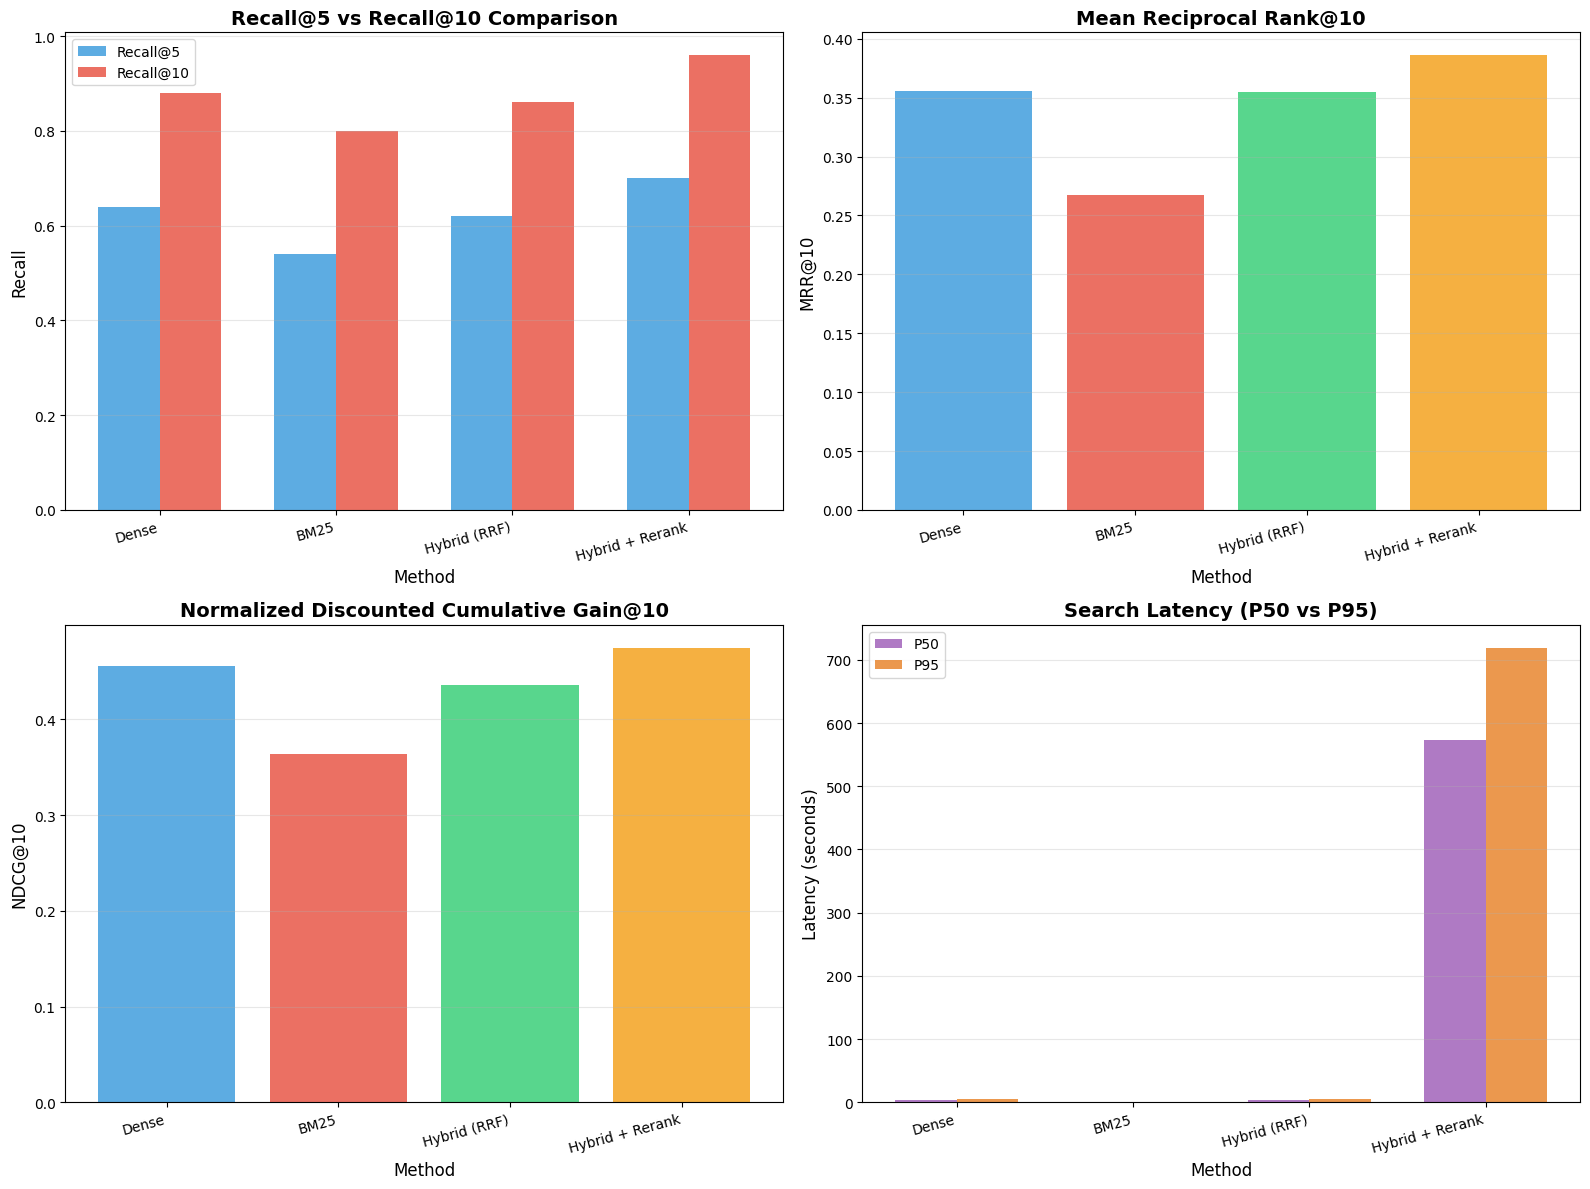

In [14]:
# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = metrics_summary['Method'].tolist()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. Recall ÎπÑÍµê
x = np.arange(len(methods))
width = 0.35
axes[0, 0].bar(x - width/2, metrics_summary['Recall@5'], width, label='Recall@5', color=colors[0], alpha=0.8)
axes[0, 0].bar(x + width/2, metrics_summary['Recall@10'], width, label='Recall@10', color=colors[1], alpha=0.8)
axes[0, 0].set_xlabel('Method', fontsize=12)
axes[0, 0].set_ylabel('Recall', fontsize=12)
axes[0, 0].set_title('Recall@5 vs Recall@10 Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(methods, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. MRR@10
axes[0, 1].bar(methods, metrics_summary['MRR@10'], color=colors, alpha=0.8)
axes[0, 1].set_xlabel('Method', fontsize=12)
axes[0, 1].set_ylabel('MRR@10', fontsize=12)
axes[0, 1].set_title('Mean Reciprocal Rank@10', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(methods, rotation=15, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. NDCG@10
axes[1, 0].bar(methods, metrics_summary['NDCG@10'], color=colors, alpha=0.8)
axes[1, 0].set_xlabel('Method', fontsize=12)
axes[1, 0].set_ylabel('NDCG@10', fontsize=12)
axes[1, 0].set_title('Normalized Discounted Cumulative Gain@10', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(methods, rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Latency
x = np.arange(len(methods))
axes[1, 1].bar(x - width/2, metrics_summary['Latency (P50)'], width, label='P50', color='#9b59b6', alpha=0.8)
axes[1, 1].bar(x + width/2, metrics_summary['Latency (P95)'], width, label='P95', color='#e67e22', alpha=0.8)
axes[1, 1].set_xlabel('Method', fontsize=12)
axes[1, 1].set_ylabel('Latency (seconds)', fontsize=12)
axes[1, 1].set_title('Search Latency (P50 vs P95)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(methods, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n‚úÖ Comparison plot saved to: {PLOTS_DIR / 'metrics_comparison.png'}")
plt.show()

‚úÖ Improvement plot saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/improvement_over_baseline.png


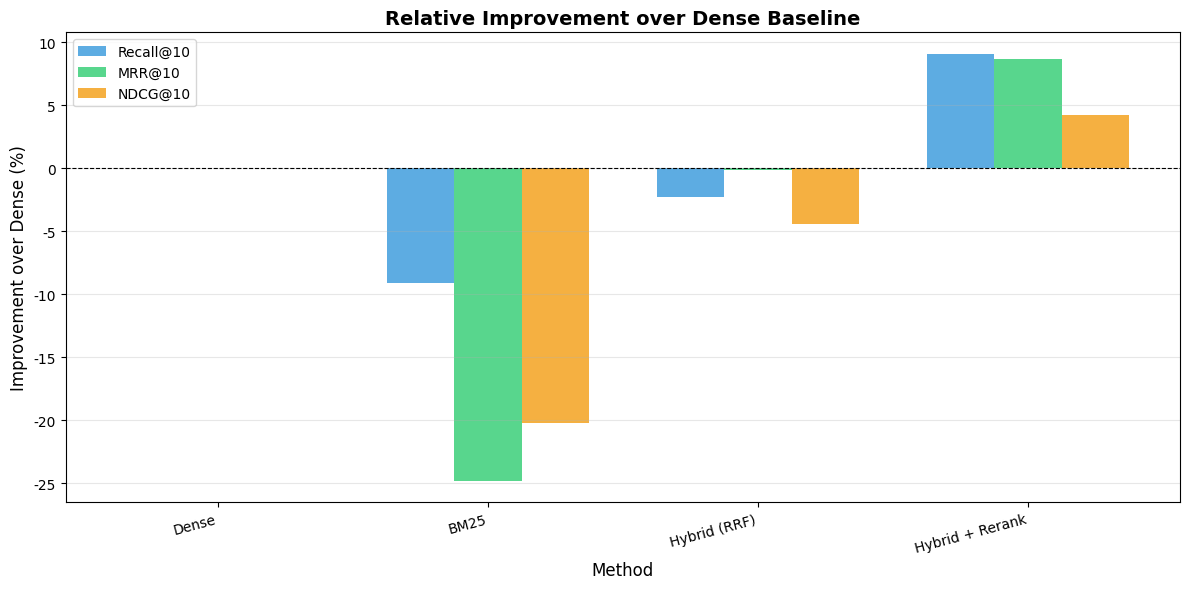


üìä Improvement over Dense Baseline:
         Method  Recall@10 Improvement  MRR@10 Improvement  NDCG@10 Improvement
          Dense               0.000000            0.000000             0.000000
           BM25              -9.090909          -24.812954           -20.220230
   Hybrid (RRF)              -2.272727           -0.111669            -4.389718
Hybrid + Rerank               9.090909            8.681184             4.252074


In [15]:
# Í∞úÏÑ† Ìè≠ Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
baseline = metrics_summary[metrics_summary['Method'] == 'Dense'].iloc[0]

improvement_data = []
for _, row in metrics_summary.iterrows():
    improvement_data.append({
        'Method': row['Method'],
        'Recall@10 Improvement': (row['Recall@10'] - baseline['Recall@10']) / baseline['Recall@10'] * 100 if baseline['Recall@10'] > 0 else 0,
        'MRR@10 Improvement': (row['MRR@10'] - baseline['MRR@10']) / baseline['MRR@10'] * 100 if baseline['MRR@10'] > 0 else 0,
        'NDCG@10 Improvement': (row['NDCG@10'] - baseline['NDCG@10']) / baseline['NDCG@10'] * 100 if baseline['NDCG@10'] > 0 else 0
    })

improvement_df = pd.DataFrame(improvement_data)

# Í∞úÏÑ† Ìè≠ ÌîåÎ°Ø
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(methods))
width = 0.25

ax.bar(x - width, improvement_df['Recall@10 Improvement'], width, label='Recall@10', color='#3498db', alpha=0.8)
ax.bar(x, improvement_df['MRR@10 Improvement'], width, label='MRR@10', color='#2ecc71', alpha=0.8)
ax.bar(x + width, improvement_df['NDCG@10 Improvement'], width, label='NDCG@10', color='#f39c12', alpha=0.8)

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Improvement over Dense (%)', fontsize=12)
ax.set_title('Relative Improvement over Dense Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'improvement_over_baseline.png', dpi=300, bbox_inches='tight')
print(f"‚úÖ Improvement plot saved to: {PLOTS_DIR / 'improvement_over_baseline.png'}")
plt.show()

print("\nüìä Improvement over Dense Baseline:")
print(improvement_df.to_string(index=False))

## 6. ÏßàÏ†Å Î∂ÑÏÑù (Success & Failure Cases)

In [17]:
# ÏÑ±Í≥µ Î∞è Ïã§Ìå® ÏÇ¨Î°Ä Î∂ÑÏÑù
# NOTE: Avoid global name collision with `rerank_results` (dict) by using local helpers here.

def _local_rerank(query: str, results: List[Dict], top_k: int = 10) -> List[Dict]:
    """
    Local reranker to avoid calling the globally shadowed rerank_results.
    """
    if not results:
        return []

    pairs = [[query, r['text']] for r in results]
    scores = reranker_model.predict(pairs, batch_size=config['reranker']['batch_size'])

    decorated = []
    for i, r in enumerate(results):
        rr = r.copy()
        rr['rerank_score'] = float(scores[i])
        rr['original_score'] = float(r.get('score', 0.0))
        rr['score'] = float(scores[i])
        decorated.append(rr)

    return sorted(decorated, key=lambda x: x['rerank_score'], reverse=True)[:top_k]


def _local_hybrid_rerank_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    # Fetch candidates using existing hybrid_search, then rerank locally
    candidates = hybrid_search(
        query,
        method=method,
        top_k=config['reranker']['top_n']
    )
    return _local_rerank(query, candidates, top_k=top_k)


def analyze_quality_examples(eval_queries: pd.DataFrame, num_examples: int = 5):
    """
    ÏßàÏ†Å Î∂ÑÏÑùÏùÑ ÏúÑÌïú ÏÑ±Í≥µ/Ïã§Ìå® ÏÇ¨Î°Ä Ï∂îÏ∂ú
    """
    examples = []

    for idx in range(min(num_examples, len(eval_queries))):
        query_row = eval_queries.iloc[idx]
        query = query_row['question']
        ground_truth = query_row['ground_truth_chunk_id']

        # 4Í∞ÄÏßÄ Î∞©Î≤ïÏúºÎ°ú Í≤ÄÏÉâ
        dense_res = dense_search(query, top_k=5)
        bm25_res = bm25_search(query, top_k=5)
        hybrid_res = hybrid_search(query, method='rrf', top_k=5)
        # Use local hybrid+rerank to avoid global name collision
        rerank_res = _local_hybrid_rerank_search(query, method='rrf', top_k=5)

        # Ï†ïÎãµ Ìè¨Ìï® Ïó¨Î∂Ä
        dense_hit = ground_truth in [r['chunk_id'] for r in dense_res]
        bm25_hit = ground_truth in [r['chunk_id'] for r in bm25_res]
        hybrid_hit = ground_truth in [r['chunk_id'] for r in hybrid_res]
        rerank_hit = ground_truth in [r['chunk_id'] for r in rerank_res]

        example = {
            'query': query,
            'ground_truth_answer': query_row['ground_truth_answer'],
            'dense_hit': dense_hit,
            'bm25_hit': bm25_hit,
            'hybrid_hit': hybrid_hit,
            'rerank_hit': rerank_hit,
            'dense_top1': dense_res[0]['text'][:200] if dense_res else 'N/A',
            'rerank_top1': rerank_res[0]['text'][:200] if rerank_res else 'N/A'
        }

        examples.append(example)

    return examples


# ÏÇ¨Î°Ä Î∂ÑÏÑù
quality_examples = analyze_quality_examples(eval_queries_df, num_examples=10)

# Markdown ÌååÏùºÎ°ú Ï†ÄÏû•
with open(RESULTS_DIR / 'qual_examples.md', 'w', encoding='utf-8') as f:
    f.write("# Quality Analysis: Success & Failure Cases\n\n")

    for i, ex in enumerate(quality_examples, 1):
        f.write(f"## Example {i}\n\n")
        f.write(f"**Query:** {ex['query']}\n\n")
        f.write(f"**Ground Truth Answer:** {ex['ground_truth_answer']}\n\n")

        f.write("### Results:\n\n")
        f.write(f"- Dense: {'‚úÖ HIT' if ex['dense_hit'] else '‚ùå MISS'}\n")
        f.write(f"- BM25: {'‚úÖ HIT' if ex['bm25_hit'] else '‚ùå MISS'}\n")
        f.write(f"- Hybrid: {'‚úÖ HIT' if ex['hybrid_hit'] else '‚ùå MISS'}\n")
        f.write(f"- Hybrid+Rerank: {'‚úÖ HIT' if ex['rerank_hit'] else '‚ùå MISS'}\n\n")

        f.write("### Top-1 Retrieved (Dense):\n")
        f.write(f"```\n{ex['dense_top1']}...\n```\n\n")

        f.write("### Top-1 Retrieved (Hybrid+Rerank):\n")
        f.write(f"```\n{ex['rerank_top1']}...\n```\n\n")

        # ÏõêÏù∏ Î∂ÑÏÑù
        if ex['rerank_hit'] and not ex['dense_hit']:
            f.write("**‚ú® Success Case:** Hybrid+Rerank successfully retrieved the answer!\n")
            f.write("**Reason:** Likely due to better fusion and reranking.\n\n")
        elif not ex['rerank_hit']:
            f.write("**‚ö†Ô∏è Failure Case:** All methods failed to retrieve the answer.\n")
            f.write("**Possible Reasons:** Chunking issue, vocabulary mismatch, or complex query.\n\n")

        f.write("---\n\n")

print(f"\n‚úÖ Quality examples saved to: {RESULTS_DIR / 'qual_examples.md'}")


‚úÖ Quality examples saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/qual_examples.md


## 7. ÏµúÏ¢Ö ÏöîÏïΩ

In [18]:
print("\n" + "="*80)
print("üéâ Assignment 02 - Search & Evaluation Complete!")
print("="*80)

print("\nüìä Final Metrics Summary:")
print(metrics_summary.to_string(index=False))

print("\nüìÅ Generated Files:")
print(f"  - {RESULTS_DIR / 'metrics.csv'}")
print(f"  - {PLOTS_DIR / 'metrics_comparison.png'}")
print(f"  - {PLOTS_DIR / 'improvement_over_baseline.png'}")
print(f"  - {RESULTS_DIR / 'qual_examples.md'}")

print("\nüìù Next Steps:")
print("  1. Review quality examples in qual_examples.md")
print("  2. Analyze failure cases and improvement opportunities")
print("  3. Create PDF report with findings")
print("  4. Invite instructor to Pinecone project")
print("  5. Submit all deliverables")

print("\n" + "="*80)


üéâ Assignment 02 - Search & Evaluation Complete!

üìä Final Metrics Summary:
         Method  Recall@5  Recall@10   MRR@10  NDCG@10  Latency (P50)  Latency (P95)
          Dense      0.64       0.88 0.355357 0.455610       3.945591       5.383369
           BM25      0.54       0.80 0.267183 0.363485       0.005177       0.017742
   Hybrid (RRF)      0.62       0.86 0.354960 0.435610       3.903644       5.404617
Hybrid + Rerank      0.70       0.96 0.386206 0.474983     572.790959     719.366606

üìÅ Generated Files:
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/metrics.csv
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/metrics_comparison.png
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/improvement_over_baseline.png
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/qual_examples.md

üìù Next Steps:
  1. Review quality examples in qual_examples.md
  2. Analyze failure cases and improvement